# Exploratory Data Analysis

KLUE Sentence-Level Relation Extration Task의 데이터셋을 살펴보자. Train 데이터는 32470개, test 데이터는 7765개이며 dev 데이터셋은 따로 주어지지 않았다.

각 데이터에는 총 5가지의 properties가 있다:

1. Sentence(문장)
2. Subject Entity(주어) 
3. Object Entity(목적어)
4. Relation Label (관계 라벨)
5. Source(출처).

우리가 해결하고 싶은 task는 문장과 subject, object entity pair $(e_{subj},e_{obj})$ 가 주어졌을 때 relation label를 예측하는 것이다.

Relation label은 총 30가지이며 18 person-related relations(인간관계), 11 organization-related relations(조직관계), and no_relation(무관계)로 나눠진다.

자세한 설명은 아래 KLUE 논문에서 가지고 온 테이블에서 확인 가능하다.

![](assets/table10.png)

"We evaluate a model using micro F1 score, computed after
excluding no_relation, and area under the precision-recall curve including all 30 classes."

Reference:
https://arxiv.org/pdf/2105.09680.pdf


In [119]:
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

In [120]:
train_path = '../dataset/train/train.csv'
test_path = '../dataset/test/test_data.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [121]:
train.head()

,id,sentence,subject_entity,object_entity,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia


In [122]:
test.head()

,id,sentence,subject_entity,object_entity,label,source
0,0,지난 15일 MBC '탐사기획 스트레이트'가 이 사실을 보도했다.,"{'word': 'MBC', 'start_idx': 7, 'end_idx': 9, ...","{'word': '탐사기획 스트레이트', 'start_idx': 12, 'end_i...",100,wikitree
1,1,사랑스러운 ‘프린세스 프링’의 이름은 봄의 공주님: Princess(s)Pring이...,"{'word': '프린세스 프링', 'start_idx': 7, 'end_idx':...","{'word': '공주', 'start_idx': 84, 'end_idx': 85,...",100,wikipedia
2,2,"한편, 본인(이근안)을 모델로 한 MBC 특집드라마 가 1995년 6.25 특집극으...","{'word': '경찰', 'start_idx': 121, 'end_idx': 12...","{'word': '1995년', 'start_idx': 31, 'end_idx': ...",100,wikipedia
3,3,정창손은 김질과 같이 대궐로 달려가 고변하며 '신은 실로 모르고 김질만 혼자 참여하...,"{'word': '세조', 'start_idx': 78, 'end_idx': 79,...","{'word': '정창손', 'start_idx': 0, 'end_idx': 2, ...",100,wikipedia
4,4,"당시 민주당 이진련 시의원은 권영진 시장에게 ""긴급 생계자금을 왜 현금으로 지원하지...","{'word': '민주당', 'start_idx': 3, 'end_idx': 5, ...","{'word': '권영진', 'start_idx': 16, 'end_idx': 18...",100,wikitree


## 전처리

subject_entity, object_entity 부분이 보기가 너무 어렵다.

In [123]:
train_subject_word = train.subject_entity.apply(lambda x : x.split("'")[3])
train_subject_type = train.subject_entity.apply(lambda x : x.split("'")[-2])
train_object_word = train.object_entity.apply(lambda x : x.split("'")[3])
train_object_type = train.object_entity.apply(lambda x : x.split("'")[-2])

train.insert(3,'object_type',train_object_type)
train.insert(3,'object_word',train_object_word)
train.insert(3,'subject_type',train_subject_type)
train.insert(3,'subject_word',train_subject_word)

train = train.drop(columns = ['subject_entity','object_entity'])


test_subject_word = test.subject_entity.apply(lambda x : x.split("'")[3])
test_subject_type = test.subject_entity.apply(lambda x : x.split("'")[-2])
test_object_word = test.object_entity.apply(lambda x : x.split("'")[3])
test_object_type = test.object_entity.apply(lambda x : x.split("'")[-2])

test.insert(3,'object_type',test_object_type)
test.insert(3,'object_word',test_object_word)
test.insert(3,'subject_type',test_subject_type)
test.insert(3,'subject_word',test_subject_word)

test = test.drop(columns = ['subject_entity','object_entity'])

In [124]:
train.head()

,id,sentence,subject_word,subject_type,object_word,object_type,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,비틀즈,ORG,조지 해리슨,PER,no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,민주평화당,ORG,대안신당,ORG,no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,광주FC,ORG,한국프로축구연맹,ORG,org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,아성다이소,ORG,박정부,PER,org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,요미우리 자이언츠,ORG,1967,DAT,no_relation,wikipedia


In [125]:
test.head()

,id,sentence,subject_word,subject_type,object_word,object_type,label,source
0,0,지난 15일 MBC '탐사기획 스트레이트'가 이 사실을 보도했다.,MBC,ORG,탐사기획 스트레이트,ORG,100,wikitree
1,1,사랑스러운 ‘프린세스 프링’의 이름은 봄의 공주님: Princess(s)Pring이...,프린세스 프링,PER,공주,POH,100,wikipedia
2,2,"한편, 본인(이근안)을 모델로 한 MBC 특집드라마 가 1995년 6.25 특집극으...",경찰,ORG,1995년,DAT,100,wikipedia
3,3,정창손은 김질과 같이 대궐로 달려가 고변하며 '신은 실로 모르고 김질만 혼자 참여하...,세조,PER,정창손,PER,100,wikipedia
4,4,"당시 민주당 이진련 시의원은 권영진 시장에게 ""긴급 생계자금을 왜 현금으로 지원하지...",민주당,ORG,권영진,PER,100,wikitree


## Check for missing values

아래에 보다사피 Null values들은 없다.

In [126]:
print('train data')
print(train.isnull().sum())
print('-' * 50)
print('test data')
print(test.isnull().sum())

train data
id              0
sentence        0
subject_word    0
subject_type    0
object_word     0
object_type     0
label           0
source          0
dtype: int64
--------------------------------------------------
test data
id              0
sentence        0
subject_word    0
subject_type    0
object_word     0
object_type     0
label           0
source          0
dtype: int64


## Sentence Analysis

데이터는 총 32470개인데 unique sentences는 28803개 인 것을 확인할 수 있다. 이 사실을 통해 여러 entity pair가 존재한 문장들도 학습 데이터로 포함이 되었다고 볼 수 있다. 정확히는 3번 중복되는 sentences는 244개, 2번 중복되는 sentences는 3179개, 그리고 한번만 등장하는 문장은 25380개 이다.
띄어쓰기를 포함한 평균 문장 길이는 97이며 최대 길이가 455이다.


In [127]:
train_sentence_length = train.sentence.apply(len)
train.insert(2, "sentence_length", train_sentence_length)
train_sentence_length.describe()

count    32470.000000
mean        97.083954
std         47.939902
min         14.000000
25%         64.000000
50%         87.000000
75%        118.000000
max        455.000000
Name: sentence, dtype: float64

In [128]:
train.nunique()

id                 32470
sentence           28803
sentence_length      361
subject_word       12052
subject_type           2
object_word        10224
object_type            6
label                 30
source                 3
dtype: int64

In [129]:
sentence_count = train.sentence.value_counts()
sentence_count.unique()

array([3, 2, 1])

In [130]:
pd.DataFrame(sentence_count).pivot_table(columns=['sentence'], aggfunc='size')

sentence
1    25380
2     3179
3      244
dtype: int64

Text(0.5, 1.0, 'Sentence Length Histogram')

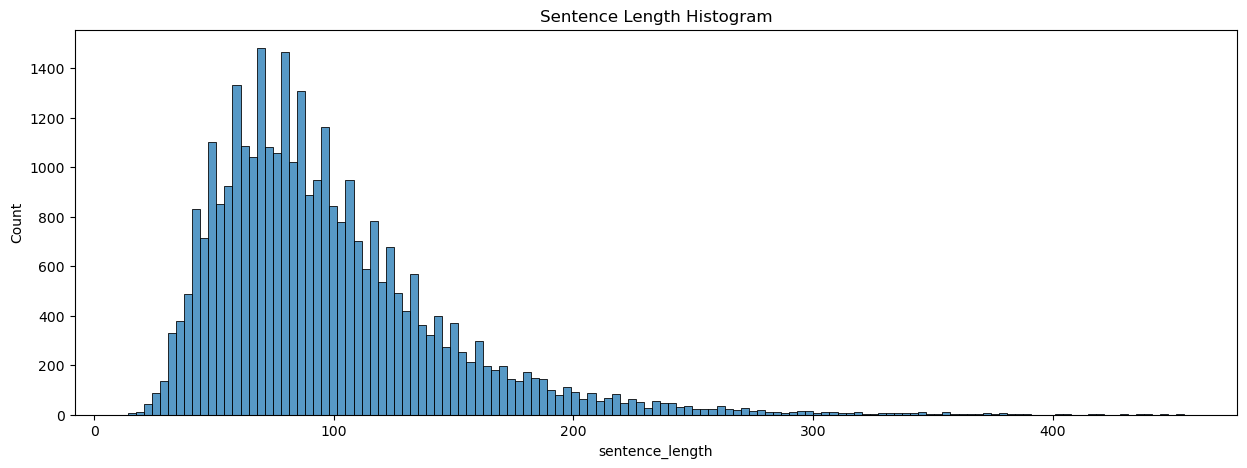

In [131]:
fig = plt.subplots(1,1, figsize=(15, 5))
sns.histplot(data=train, x="sentence_length")
plt.title("Sentence Length Histogram")

Text(0.5, 1.0, 'Sentence Length distribution per label')

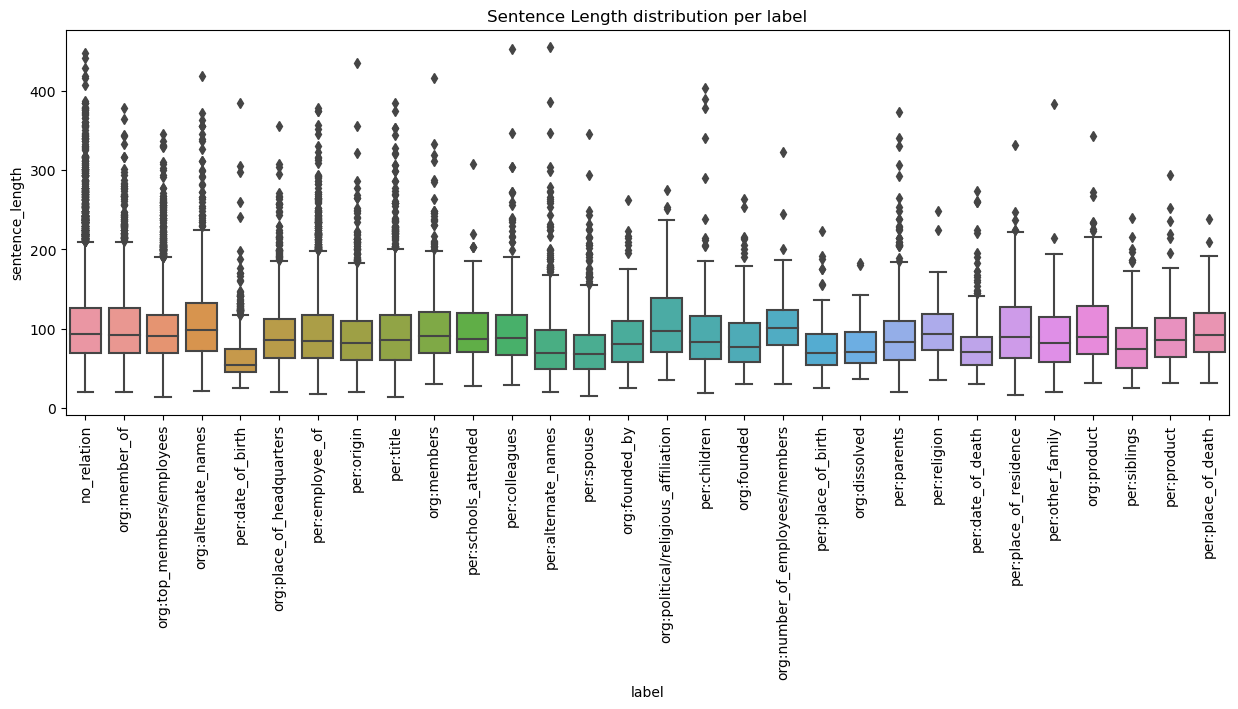

In [132]:
fig, ax = plt.subplots(1,1, figsize=(15, 5))
sns.boxplot(data=train, x='label', y='sentence_length')
plt.xticks(rotation=90)
plt.title("Sentence Length distribution per label")

## Token Analysis

최대 토큰 길이는 229인 것으로 확인이 되고 [UNK] token이 포함된 문장의 개수는 32470 문장 중 3218개이다. 문장은 다 합쳤다고 가정을 했을 때 총 [UNK]의 개수는 6313개이다.

In [133]:
train_token = train.sentence.apply(tokenizer.tokenize)
train_token_length = train_token.apply(len)
train_token_length.describe()

count    32470.000000
mean        50.958608
std         24.921942
min          7.000000
25%         34.000000
50%         46.000000
75%         62.000000
max        229.000000
Name: sentence, dtype: float64

In [134]:
df_train_token=pd.DataFrame(data=train_token, columns = ['sentence'])
df_train_token.insert(1, "token_length", train_token_length)
df_train_token.rename(columns = {'sentence':'token'}, inplace=True)

In [135]:
count = 0
for i in range(len(train)):
    if '[UNK]' in df_train_token.token[i]:
        count += 1
print(f'number of sentences containing [UNK]: {count} out of {len(train)}')

number of sentences containing [UNK]: 3218 out of 32470


In [136]:
all_token_list = []
for i in range(len(train)):
    all_token_list += train_token[i]

In [137]:
token_count = Counter(all_token_list)
token_count.most_common()

[(',', 37642),
 ('.', 36210),
 ('##의', 34920),
 ('##다', 29480),
 ('##을', 29307),
 ('##에', 25994),
 ('##는', 24825),
 ('##년', 20918),
 ('(', 19211),
 (')', 19190),
 ('##이', 18360),
 ('##를', 16525),
 ('##은', 13806),
 ('##일', 13506),
 ('##하', 13031),
 ('##로', 12635),
 ('##에서', 12159),
 ('##가', 11753),
 ('##월', 11192),
 ('##고', 11073),
 ('##으로', 10444),
 ('##했', 10382),
 ('##한', 9807),
 ('##과', 8458),
 ('##었', 7760),
 ('##인', 7708),
 ('##와', 7331),
 ('##였', 6952),
 ('있', 6766),
 ('[UNK]', 6313),
 ("'", 6148),
 ('"', 5408),
 ('##대', 5170),
 ('1', 4967),
 ('##게', 4951),
 ('##지', 4908),
 ('##되', 4872),
 ('등', 4848),
 ('##도', 4719),
 ('##당', 4694),
 ('2', 4516),
 ('##이다', 4484),
 ('##자', 4369),
 ('##기', 4101),
 ('이', 4065),
 ('##들', 3933),
 ('##하고', 3856),
 ('3', 3732),
 ('##스', 3603),
 ('##시', 3564),
 ('##장', 3458),
 ('##어', 3422),
 ('그', 3403),
 ('##해', 3359),
 ('##세', 3331),
 ('##며', 3316),
 ('는', 3262),
 ('##던', 3222),
 ('~', 3159),
 ('4', 3025),
 ('-', 3025),
 ('##원', 2979),
 ('##서', 2975)

## Subject, Object Entity Analysis

Entity type으로는 PER(사람), ORG(조직), DAT(시간), LOC(장소), POH(기타 표현), NOH(기타 수량 표현) 총 6가지가 존재하며 이 중 subject entity 단어는 PER과 ORG entity type 밖에 안사용이 되며 Object Entity 단어는 모든 6가지 Type의 단어가 사용된다.

질문: 왜 그럴까? 답은 회의 때

In [138]:
train_subject_word = train.subject_word.value_counts()
train_subject_word.head(10)

민주당       144
화순군       107
고흥군        99
광주광역시      92
더불어민주당     92
여수시        82
목포시        80
문재인        80
영암군        75
포천시        73
Name: subject_word, dtype: int64

In [139]:
train_subject_word.describe()

count    12052.000000
mean         2.694159
std          5.103417
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        144.000000
Name: subject_word, dtype: float64

In [140]:
train_object_word = train.object_word.value_counts()
train_object_word.head(10)

대한민국      276
자유한국당     268
더불어민주당    236
문재인       135
UEFA      117
캐나다       115
스페인       113
김대중       113
정의당       111
골키퍼       110
Name: object_word, dtype: int64

In [141]:
train_object_word.describe()

count    10224.000000
mean         3.175861
std          8.563621
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        276.000000
Name: object_word, dtype: float64

In [142]:
train_subject_type = train.subject_type.value_counts()
train_subject_type.head(10)

PER    16786
ORG    15684
Name: subject_type, dtype: int64

In [143]:
train_object_type = train.object_type.value_counts()
train_object_type.head(10)

PER    9788
ORG    9346
POH    5113
DAT    4249
LOC    3561
NOH     413
Name: object_type, dtype: int64

## Label Analysis

no relation이 많은 이유는 KLUE 논문에서 나와있다.
- Irrelevant pairs will account for a large portion of realistic relation distribution between two arbitrary
entities. Therefore, this approach helps to set up real-world scenario.

즉 현실을 바탕으로 데이터셋을 만들었는데 현실에서는 무관계인 객체 쌍들이 많이 존재할 거라서 그랬다고 한다.


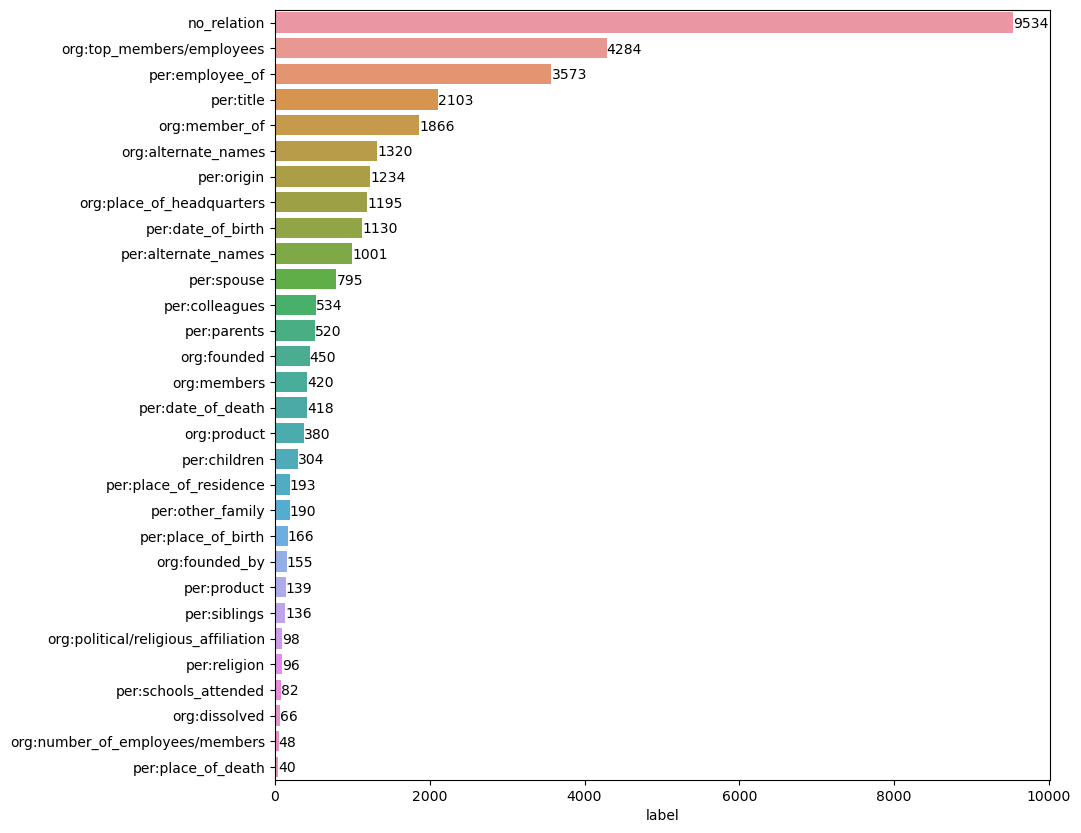

In [144]:
train_label = train.label.value_counts()
df_train_label = pd.DataFrame(train_label)
fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.barplot(y=df_train_label.index, x=df_train_label.label)

for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_width()), (p.get_x() + p.get_width(), p.get_y()+0.6), fontsize=10)

plt.show()

In [145]:
train_size = len(train)
train_label_per = df_train_label.label.apply(lambda x : x * 100 / train_size)
type(train_label_per)
df_train_label.insert(1, "train_label_per",train_label_per)

In [146]:
df_train_label.head()

,label,train_label_per
no_relation,9534,29.362488
org:top_members/employees,4284,13.193717
per:employee_of,3573,11.004004
per:title,2103,6.476748
org:member_of,1866,5.746843


## Source

wikitree는 https://www.wikitree.co.kr/

wikipedia는 https://ko.wikipedia.org/

policy_briefing은 https://www.korea.kr/main.do


In [147]:
print('train data')
print(train['source'].value_counts())
print('-' * 50)
print('test data')
print(test['source'].value_counts())

train data
wikipedia          21620
wikitree           10672
policy_briefing      178
Name: source, dtype: int64
--------------------------------------------------
test data
wikitree           4088
wikipedia          3621
policy_briefing      56
Name: source, dtype: int64


In [148]:
train_source = list(train['source'].value_counts())
test_source = list(test['source'].value_counts())

train_source_per = [i *100 / sum(train_source) for i in train_source]
test_source_per = [i *100 / sum(test_source) for i in test_source]

df_source = pd.DataFrame(data={'wikitree':[train_source_per[0],test_source_per[0]],'wikipedia':[train_source_per[1],test_source_per[1]],'policy_briefing':[train_source_per[2],test_source_per[2]], 'dataset_type':['train','test']})


In [149]:
df_source

,wikitree,wikipedia,policy_briefing,dataset_type
0,66.584540,32.867262,0.548198,train
1,52.646491,46.632325,0.721185,test


In [150]:
train_subject_type.unique()

array([16786, 15684])